Problem Stetment

In [43]:
# Import necessary libraries
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white backround for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [44]:
dataset = MNIST(root = 'data', download = True, transform = ToTensor())

In [45]:
#length of dataset
len(dataset)

60000

In [46]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [47]:
image, label = dataset[0]
print('image.shape:',image.shape)

image.shape: torch.Size([1, 28, 28])


Matplotlib cann't plot an image shape of 1x28x28. The color channel must be on the last dimension. So we need to change its dimension using permute function.

In [48]:
image_permuted = image.permute(1,2,0)
image_permuted.shape

torch.Size([28, 28, 1])

Label: 5


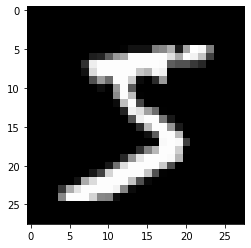

In [49]:
plt.imshow(image[0],cmap='gray')
print('Label:', label)

Next, let's use the random_split helper function to set train and validation dataset

In [50]:
val_size = 10000
train_size = len(dataset)-val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

**epoch** = 1 forward and backward pass of all training samples

**batch_size** = number of training samples in one forward and backward pass

e.g. 100 samples, batch_size = 20 -->100/20 = 5 iterations for 1 epoch

As data storage is often slow, in particular due to access latency, we want to parallelize data loading. But as the many things Python is well loved for do not include easy, efficient, parallel processing, we will need multiple processes to load our data, in order to assemble them into batches: tensors that encompass several samples. This is rather elaborate; but as it is also relatively generic, PyTorch readily provides all that magic in the **DataLoader** class. Its instances can spawn child processes to load data from a dataset in the background so that it’s ready and waiting for the training loop as soon as the loop can use it.

In [51]:
batch_size = 128

In [52]:
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [53]:
for images, _ in train_loader:
  print('images.shape:', images.shape)
  print('grid.shape',make_grid(images, nrow=16).shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])
grid.shape torch.Size([3, 242, 482])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


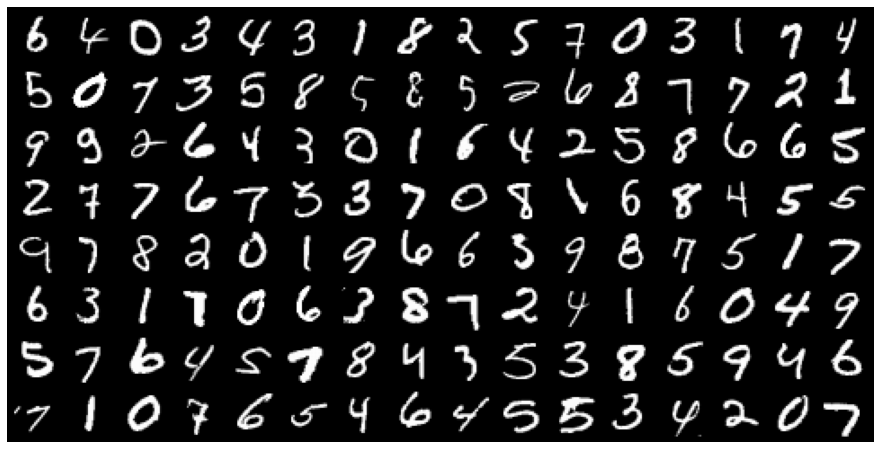

In [54]:
for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize = (16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16).permute((1,2,0)))
  break

## Hidden Layers, Activation Functions and Non-Linearity
We'll create a neural network with two layers: a hidden layer and an output layer. Additionally, we'll use an activation function between the two layers. 

First, let's create a batch of inputs tensors. We'll flatten the 1x28x28 images into vectors of size 784, so they can be passed into an nn.Linear object.

In [55]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a nn.Linear object, which will serve as our hidden layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the learning capacity of the model.

In [56]:
input_size = inputs.shape[-1]
hidden_size = 32

In [57]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing inputs through layer1.

In [58]:
inputs.shape

torch.Size([128, 784])

In [59]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with the transposed weights matrix of `layer1` and adding the bias. 

In [60]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [61]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula relu(x) = max(0,x) i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

We can use the F.relu method to apply ReLU to the elements of a tensor.

In [62]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to layer1_outputs and verify that negative values were replaced with 0.

In [63]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.7204350829124451
min(relu_outputs): 0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the _activation function_, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [64]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [65]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [66]:
inputs.shape

torch.Size([128, 784])

As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [67]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.2931, grad_fn=<NllLossBackward0>)

Thus, our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`), followed by a non-linear activation (using `F.relu`), followed by another linear transformation (using `layer2`). Let's verify this by re-computing the output using basic matrix operations.

In [68]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [69]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensize matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. 

In [70]:
# Check if a GPU is available and the required NVIDIA CUDA drivers are installed using torch.cuda.is_available
torch.cuda.is_available()

True

### Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't.

In [71]:
def get_default_device():
  """ Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [72]:
device = get_default_device()
device

device(type='cuda')

Defining a function that can move data and model to a chosen device.

In [73]:
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [74]:
for images, labels in train_loader:
  print(images.shape)
  print(image.device)
  images = to_device(images, device)
  print(images.device)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
cpu
cuda:0


Finally, define a **DeviceDataLoader** class to wrap exidting data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.


In [75]:
class DeviceDataLoader():
  """Wrap a dataloader to mode data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    """Number of batches"""
    return len(self.dl)

The **yield** keyword in Python is used to create a generator function that can be used within a `for` loop, as illustrated below.

Yield is a keyword in Python that is used to return from a function without destroying the states of its local variable and when the function is called, the execution starts from the last yield statement. Any function that contains a yield keyword is termed a generator. Hence, yield is what makes a generator. The yield keyword in Python is less known but has a greater utility. we will see the yield python example.

Example below shows that we are defining a function called `some_numbers()` and instead of returning anything we just yield 3 times in a row. Everytime we do, it generates a function(some_numbers()) using yield objects. Then we just printed them using `for` loop.

In [77]:
def some_numbers():
  yield 10
  yield 20
  yield 30
for value in some_numbers():
  print(value)

10
20
30


We can now wrap our data loaders using `DeviceDataLoader`

In [78]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors moved to the GPU have a device property which includes that word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [81]:
for xb, yb in val_loader:
  print('xb.device:', xb.device)
  print('yb: ', yb)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


xb.device: cuda:0
yb:  tensor([6, 3, 1, 5, 1, 5, 8, 2, 6, 9, 0, 8, 3, 6, 0, 4, 0, 5, 2, 3, 9, 6, 5, 9,
        6, 7, 0, 8, 1, 7, 6, 6, 1, 2, 9, 2, 7, 8, 6, 3, 9, 8, 1, 5, 7, 4, 7, 8,
        0, 1, 4, 7, 3, 2, 2, 1, 3, 2, 8, 0, 5, 3, 5, 3, 6, 7, 9, 8, 9, 3, 9, 0,
        0, 4, 1, 9, 2, 2, 1, 9, 2, 6, 7, 3, 2, 1, 3, 7, 1, 6, 4, 2, 1, 9, 2, 8,
        3, 1, 9, 6, 8, 6, 4, 7, 1, 1, 1, 8, 1, 2, 6, 1, 8, 8, 6, 2, 6, 4, 3, 6,
        7, 0, 1, 4, 2, 1, 6, 0, 7, 0, 6, 7, 7, 6, 7, 1, 8, 3, 4, 0, 7, 8, 7, 6,
        1, 4, 3, 3, 7, 4, 8, 6, 1, 7, 0, 2, 2, 8, 8, 1, 5, 1, 0, 4, 9, 2, 8, 2,
        1, 3, 2, 9, 9, 6, 6, 2, 4, 0, 4, 1, 7, 2, 4, 5, 0, 0, 7, 8, 1, 0, 4, 3,
        3, 8, 3, 4, 1, 4, 7, 5, 3, 2, 2, 0, 6, 9, 5, 4, 6, 8, 6, 7, 5, 4, 4, 9,
        1, 2, 8, 0, 8, 5, 1, 0, 7, 3, 8, 1, 5, 3, 1, 0, 6, 5, 7, 4, 9, 6, 0, 7,
        7, 7, 1, 4, 7, 1, 9, 2, 3, 4, 5, 6, 0, 8, 1, 7], device='cuda:0')
